In [225]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import Model
from math import log, sqrt, exp, erf, ceil
from tqdm.notebook import tqdm, trange
import pandas as pd
from math import ceil

import scipy.stats as stats
from scipy.stats import qmc
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (20, 7)
plt.style.use('bmh')

# Quasi Monte Carlo Normal Distribution

In [153]:
from scipy.stats import norm
import math

def bs_put(S, K, T, r, sigma):
    d1 = (log(S/K)+(r+sigma**2/2.)*T)/(sigma*sqrt(T))
    d2 = d1 - sigma*sqrt(T)

    """ negative in front - negative in front of d1 """
    # D = - (1.0 + erf(-d1 / sqrt(2.0))) / 2.0
    # V = S*D + K*exp(-r*T)* (1.0 + erf(-d2 / sqrt(2.0))) / 2.0

    d1 = (math.log(S / K) + (r + sigma ** 2 / 2) * T) / (sigma * math.sqrt(T))
    d2 = d1 - sigma * math.sqrt(T)

    call_price = S * norm.cdf(d1) - K * math.exp(-r * T) * norm.cdf(d2)

    return call_price

def sobol_norm(m, d=1):
    sampler = qmc.Sobol(d, scramble=True)
    x_sobol = sampler.random_base2(m)
    return stats.norm.ppf(x_sobol)

mean St = 105.597246
r       = 0.055000 
Diff    = 104.542246


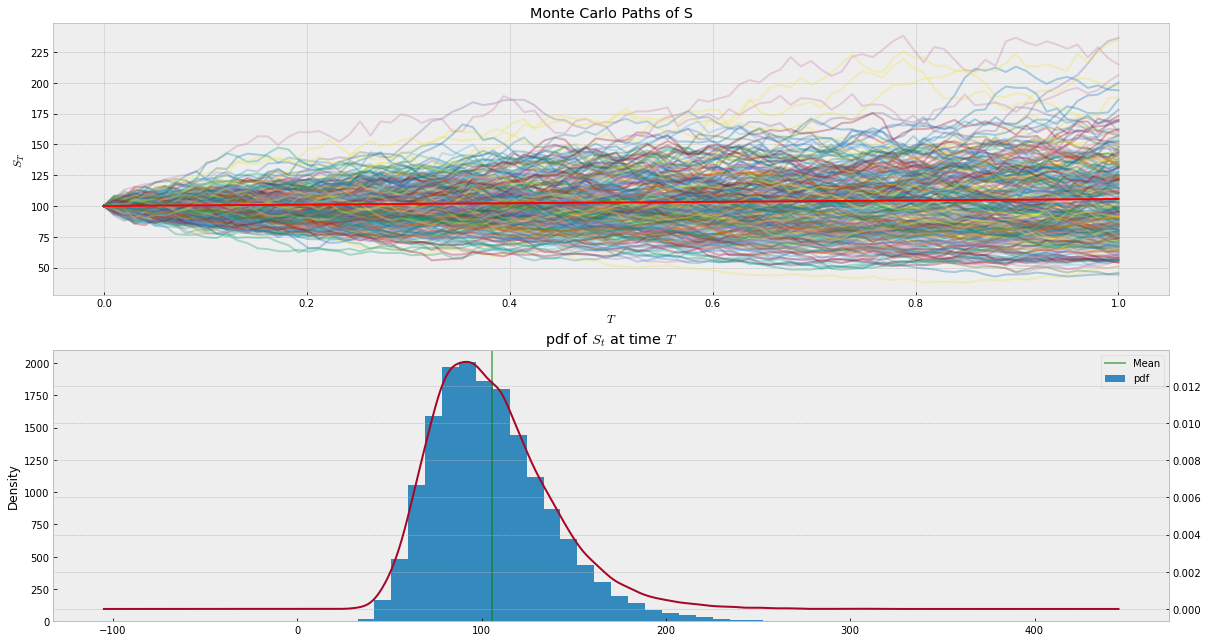

In [154]:
# %%timeit # 15.5 ms ± 870 µs per loop
n_paths   = ceil(np.log2(10_000))

S       = 100
K       = 100
T       = 1.0
r       = .055
sigma   = 0.3
dt      = 1/100

n_time_steps = int(T/dt)

""" Simulate Stock Data """
W       = sobol_norm(n_paths, d=n_time_steps)
S_paths = np.empty((2**n_paths, n_time_steps))
S_paths[:,0] = S
for t in range(1,n_time_steps):
    S_paths[:,t] = (S_paths[:,t-1] * np.exp((r-sigma**2/2)*dt + sigma * np.sqrt(dt)*W[:,t] ).squeeze())

""" Generate Bond Data """
B = np.exp(r*np.linspace(0,T, n_time_steps))
B = np.broadcast_to(B, S_paths.shape)

fig, axs = plt.subplots(2, figsize=(20,11))
print(f'mean St = {S_paths[:,t].mean():.6f}')
print(f'r       = {r:.6f} \nDiff    = {S_paths[:,t].mean() - r -1:.6f}')
rdf = pd.DataFrame(S_paths.T, index=(np.linspace(0,T, n_time_steps)))
rdf.sample(300, axis=1).plot(legend=False, alpha=.3, ylabel=r'$S_T$', xlabel=r'$T$', ax=axs[0], title='Monte Carlo Paths of S') 
axs[0].plot(np.linspace(0,T, n_time_steps), S*np.exp(r*np.linspace(0,T, n_time_steps)), c='r')

rdf.iloc[-1,:].hist(bins=30, ax=axs[1])
rdf.iloc[-1,:].plot(kind='kde', secondary_y=True, title=r'pdf of $S_t$ at time $T$', xlabel=r'S_T', ylabel='Density over 10,000 paths', ax=axs[1])
axs[1].axvline(S_paths[:,t].mean(), color='g', linestyle='-', alpha=.5)
axs[1].legend(['Mean', 'pdf'])
plt.show()

# Defining the Neural Network

In [155]:
Input_S = keras.Input(shape=(1,), name='input: S_{t} ')
x = keras.layers.Dense(8, activation='sigmoid', name='Sigmoid_1')(Input_S)
x = keras.layers.Dense(8, activation='sigmoid', name='Sigmoid_2')(x)
holdings = keras.layers.Dense(2, activation='linear', name='linear')(x)

prices_1 = keras.Input(shape=(2,), name='input: S_{t}, B_{t} ')
value    = keras.layers.Dot(axes = 1, name='V_t')([holdings, prices_1])

model = keras.Model(inputs=[Input_S, prices_1], outputs=value, name="Replicating_Portfolio")
model.summary()

Model: "Replicating_Portfolio"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input: S_{t}  (InputLayer)      [(None, 1)]          0                                            
__________________________________________________________________________________________________
Sigmoid_1 (Dense)               (None, 8)            16          input: S_{t} [0][0]              
__________________________________________________________________________________________________
Sigmoid_2 (Dense)               (None, 8)            72          Sigmoid_1[0][0]                  
__________________________________________________________________________________________________
linear (Dense)                  (None, 2)            18          Sigmoid_2[0][0]                  
______________________________________________________________________________

In [193]:
re_runs = 5
model.compile(optimizer = keras.optimizers.Adam(learning_rate=1e-2),
              loss = "mse", run_eagerly=False, 
              metrics="mae")

values = np.empty_like(S_paths)

""" Calculate: Payoff for Options """
Type = 'Call' # or put
values[:,-1] = np.maximum(S_paths[:,-1] - K, 0) if Type == 'Call' else np.maximum(K - S_paths[:,-1], 0)

flag = True
for run in range(re_runs):
    Errors = [0]
    for t_i in trange(n_time_steps-2, -1, -1):
        _ = np.stack((S_paths[:,t_i], B[:,t_i]), axis=-1)
        X0 = [S_paths[:,t_i], _]

        _ = np.stack((S_paths[:,t_i+1], B[:,t_i+1]), axis=-1)
        X1 = [S_paths[:,t_i], _]
        
        epochs = 10 if not flag else 300 ; flag = False
        model.fit(X1, values[:,t_i+1], epochs=epochs, validation_split=0.0, verbose=0, batch_size=512) #, initial_epoch= 200 if t_i != n_time_steps-2 else 0)
        # break
        values[:,t_i] = model.predict(X0, verbose=0).squeeze()
        
        if run == re_runs-1: Errors.append(model.evaluate(X1, values[:,t_i+1])[1])
        # print(f'mean Error = {np.array(Errors).mean():.5f}')
    

  0%|          | 0/99 [00:00<?, ?it/s]

2023-03-19 14:39:10.791522: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2023-03-19 14:39:41.385575: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

 29/512 [>.............................] - ETA: 1s - loss: 0.2580 - mae: 0.3568

2023-03-19 14:49:23.048170: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


512/512 [==============================] - 2s 3ms/step - loss: 0.0064 - mae: 0.0529


2023-03-19 17:52:25.447657: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Mean Phi : 0.6238 
Mean Psi : -47.9307


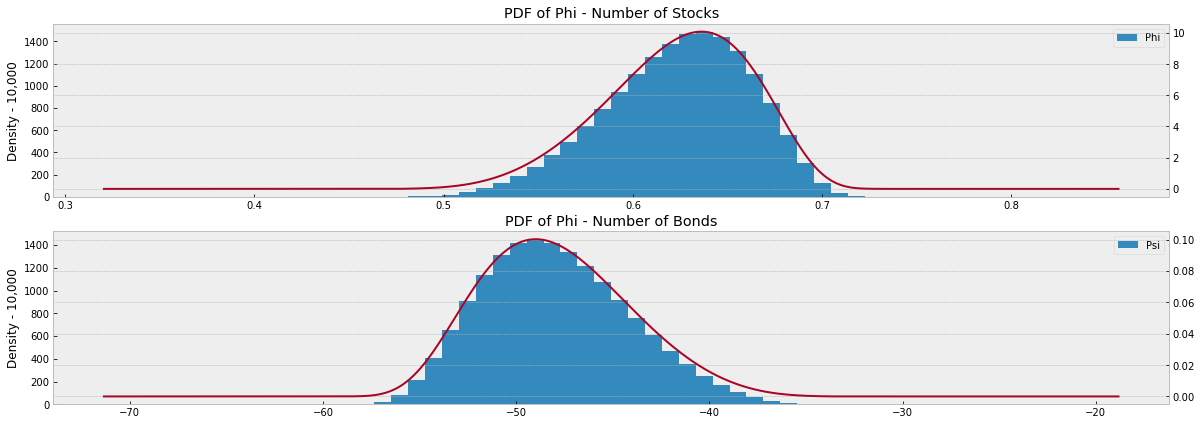

In [253]:
# for layer in model.layers:
    # weights = layer.output
    # print(weights)
    # print('----------------------------------------------------------------')


# tf.keras.models.Model(inputs=model.input,outputs=layer_output)
layer_output=model.get_layer('linear').output
inputs = S_paths[:,1]
pw_model = Model(inputs=[model.input], outputs=[layer_output])


t_i = 1
_ = np.stack((S_paths[:,t_i], B[:,t_i]), axis=-1)
X0 = [S_paths[:,t_i], _]
linear_layer_output = pw_model.predict(X0)
Phi, Psi = linear_layer_output[:,0], linear_layer_output[:,1]

data = {'Phi': Phi, 'Psi': Psi}
HP = pd.DataFrame.from_dict(data)

fig, axs = plt.subplots(2)
HP['Phi'].plot(kind='hist', bins=30, ax=axs[0], title='PDF of Phi - Number of Stocks')
HP['Phi'].plot(kind='kde', ax=axs[0], secondary_y=True)
HP['Psi'].plot(kind='hist', bins=30, ax=axs[1], title='PDF of Phi - Number of Bonds')
HP['Psi'].plot(kind='kde', ax=axs[1], secondary_y=True)
axs[0].set_ylabel('Density - 10,000') ; axs[0].legend() ; axs[1].set_ylabel('Density - 10,000') ;axs[1].legend()
print(f'Mean Phi : {HP["Phi"].mean():.4f} \nMean Psi : {HP["Psi"].mean():.4f}')


# Plot

Value at t_0 (Blach-Scholes) = 14.47320
Value at t_0 (Replicating-P) = 14.49997
Replicating-P : 2σ = 0.0508


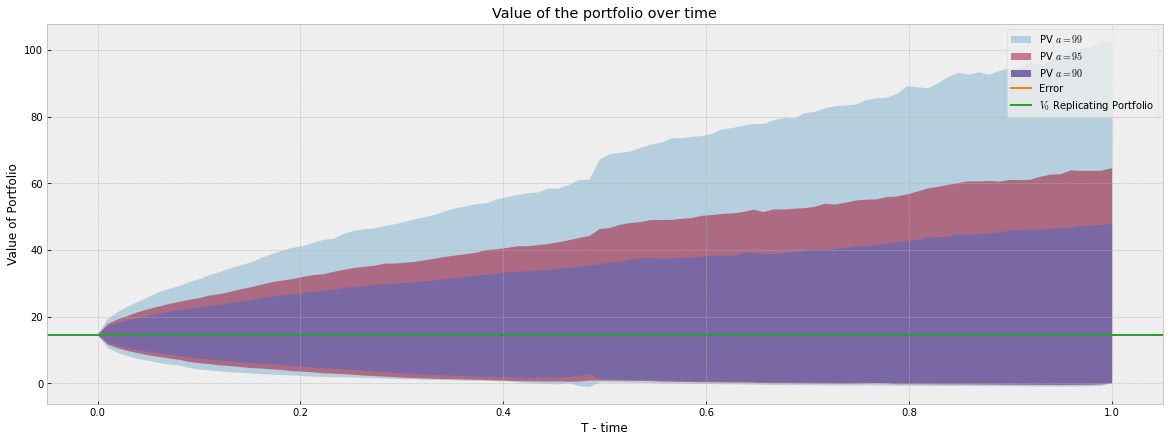

In [200]:
V0_RP = values[:,0].mean()
d = 50
while values.shape[0] % d != 0 : d += 1
std_mean = values.reshape(d, -1, int(1/dt)).mean(axis=1).std(ddof=1)
V0_RP_SE = std_mean / np.sqrt(d)
V0_BS = bs_put(S, K, T, r, sigma)
qs = np.quantile(values, q=[.99, .95, .9, .1, .05, .01], axis=0)
t  = np.linspace(0, T, int(1/dt))

fig, ax = plt.subplots()
ax.fill_between(t, qs[0,:].squeeze(), qs[-1,:].squeeze(), alpha=.3)
ax.fill_between(t, qs[1,:].squeeze(), qs[-2,:].squeeze(), alpha=.5)
ax.fill_between(t, qs[2,:].squeeze(), qs[-3,:].squeeze(), alpha=.99)
# pd.DataFrame(Errors[::-1], index=t, columns=['Error']).plot(legend=False, color='tab:red', ax=ax) #, secondary_y=True, 
ax.axhline(V0_RP, color='tab:orange')
ax.axhline(V0_BS, color='tab:green')
ax.legend([r'PV $a=99$',r'PV $a=95$',r'PV $a=90$', 'Error', r'$V_0$ Replicating Portfolio', r'$V_0$ Black-Scholes Portfolio'])
ax.set_xlabel('T - time') ; ax.set_ylabel('Value of Portfolio') ; ax.set_title('Value of the portfolio over time')

print(f'Value at t_0 (Blach-Scholes) = {V0_BS:.5f}')
print(f'Value at t_0 (Replicating-P) = {V0_RP:.5f}')
print(f'Replicating-P : 2σ = {V0_RP_SE:.4f}')

# Tune Architecture

In [201]:
# Todo: Write code for tuning the HP of the NN